this notebook is based on abTEM/example/quick_hrtem_and_saed

In [1]:
# notebook last tested with abtem version 1.0.0beta8
%matplotlib inline

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import matplotlib.pyplot as plt

from ase.visualize import view

from abtem import *

import numpy as np
import matplotlib.pyplot as plt
from abtem.potentials import PotentialArray
import scipy.constants as c
from abtem.transfer import scherzer_defocus
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

from abtem.utils import fft_shift
from abtem.utils import energy2sigma

current version: 1.0.0beta27


In [2]:
def imshow_direct(X, *args, **kwargs): 
    return plt.imshow(X=np.flip(np.swapaxes(X,0,1),axis=0),*args, **kwargs)

 # TEM simulation of phase plate

Creating potential with different values on each half plane so that the resulting phase shift will be 0 rad on the first half and 1 rad (`phase_shift`) on the second half. The artificial specimen is, thanks to it's symmetry, made in the lateral side basically one dimensional so that in x direction it's extent is $10\,\mathrm{\mu m}$ (`extent`).

The potential consists of 20 slices (`num`) each with thickness of 20 angstrom (`slice_thickness`) resulting in total thickness of $40\,\mathrm{nm}$. 

In [3]:
def get_potential(phase_shift,extent,energy,gpts,num=1): 
    # phase_shift - in rad
    # extent - in A
    # energy - in eV
    # num - number of slices of thickness `slice_thickness`
    
    sampling = extent/gpts #A #potencial will be sampled with this value 
    array=np.zeros(gpts,dtype=np.float64)

    slice_thickness = 20#2.1 #A

    ctf_tmp = CTF(energy = energy); wavelength = ctf_tmp.wavelength * 1e-10 # in meters
    electron_energy=energy*c.e #J

    #POTENTIAL
#    interaction_parameter = 2*np.pi/wavelength/electron_energy*((c.m_e*c.c**2+c.e*electron_energy)/(2*c.m_e*c.c**2+c.e*electron_energy))#kirkland (5.6) in rad/joul/meter
#    proj_pot_val = phase_shift/interaction_parameter #Jm
#    proj_pot_val_eva = proj_pot_val/(1e-10)/c.e #PotentialArray's array should be in eV*A not eV how I previously thought.. each slice contains already projected potential and total projected potencial is just sum of them

    interaction_parameter = energy2sigma(energy)
    proj_pot_val_eva = phase_shift/interaction_parameter

    y,x = np.indices(array.shape)
    array[y<gpts[0]//2] = proj_pot_val_eva # eV*A it is projected potential in a given slice

    array=array/num
    print(sampling)
    potential = PotentialArray(array=np.array([array]*num),slice_thicknesses=np.array([slice_thickness]*num),extent=extent,sampling=sampling)
    
#    proj_pot_max=np.max(potential.array)*num #eV*A
#    print(proj_pot_max) 
#    print(proj_pot_max*interaction_parameter*1e-10*c.e) # phase shift sanity check
    
    return(potential)


gpts=np.array([4096*128,4])
ex = 10e-6/1e-10 # A # sample dimensions in x and y direction # pro STEM
extent = np.array([ex, ex*gpts[1]/gpts[0]])
sampling = extent/gpts #A #potencial will be sampled with this value 
print(sampling)
#ex = 400e-10/1e-10 # A # sample dimensions in x and y direction # pro STEM
num=20
energy=200e3 #eV
potential = get_potential(phase_shift=1,extent=extent,energy=energy,gpts=gpts,num=num)

[0.19073486 0.19073486]
[0.19073486 0.19073486]


Projected potential of the created sample

Text(0, 0.5, 'projected potential ev$\\cdot\\mathrm{\\AA}$')

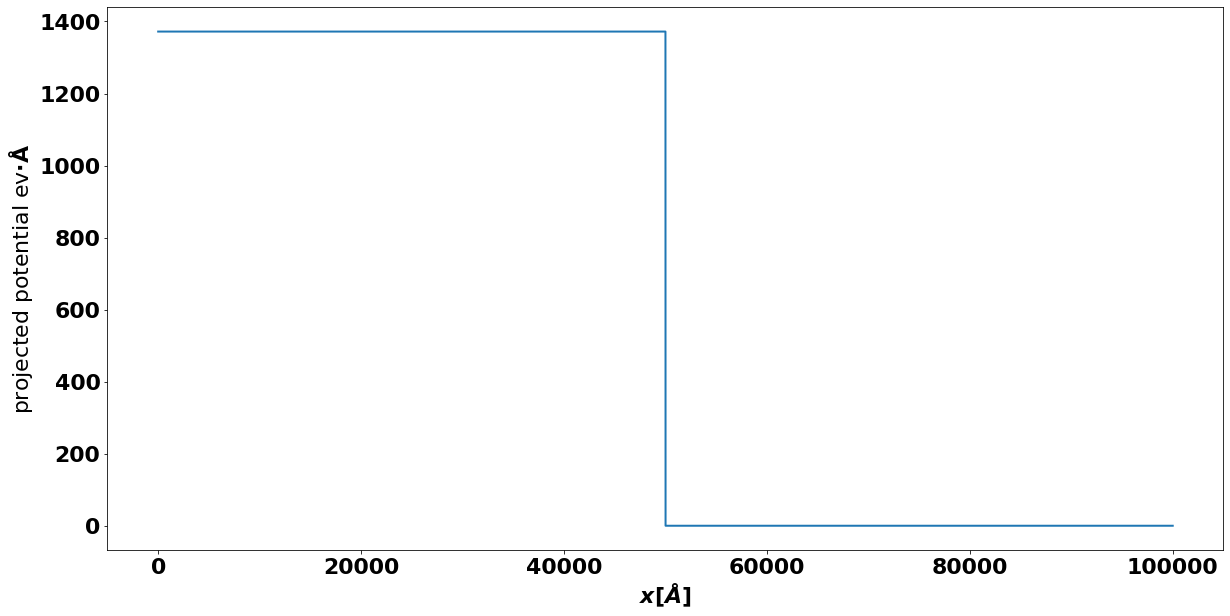

In [4]:
#potential.project().show()
#imshow_direct(potential.project().array);plt.colorbar(label="projected potential [eV$\cdot\mathrm{\AA}$]")
y=potential.project().array[:,gpts[1]//2]
x=np.linspace(0,ex,len(y))
plt.plot(x, y)
plt.xlabel("$x [\AA]$")
plt.ylabel("projected potential ev$\cdot\mathrm{\AA}$")

We create the incoming plane wave and start the multislice simulation.

In [5]:
wave = PlaneWave(
    energy=energy,extent=extent,sampling=sampling # acceleration voltage in eV
)

exit_wave = wave.multislice(potential)

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Wave intensity before hitting the sample in x direction

524288


Text(0, 0.5, 'intensity [a.u.]')

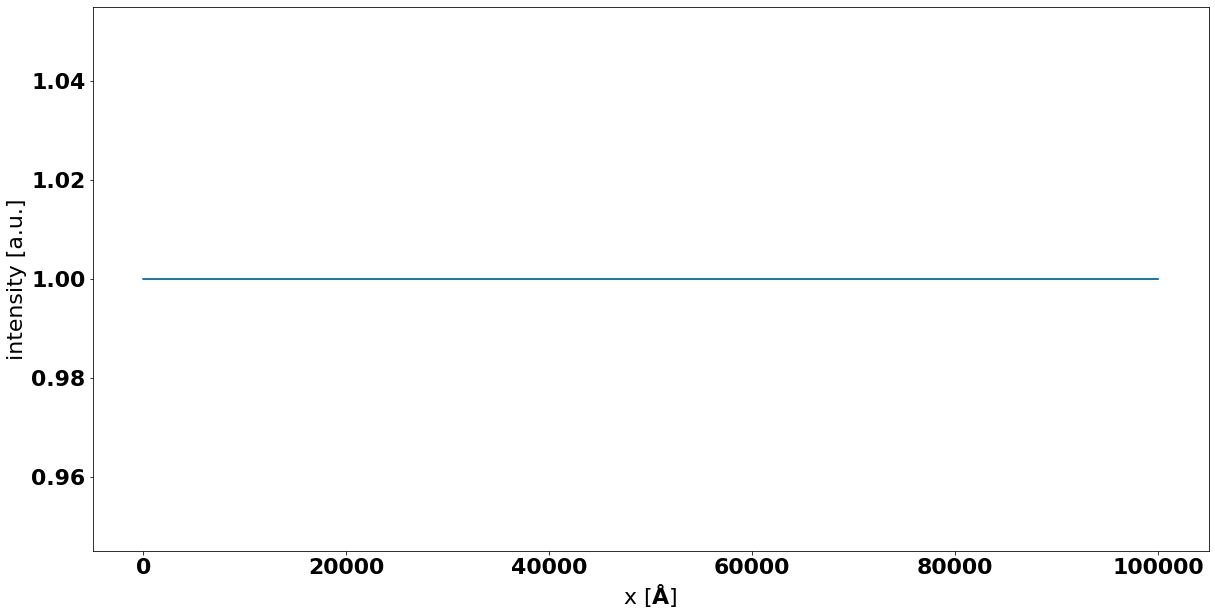

In [6]:
#wave.build().show(cmap="jet")

#imshow_direct(wave.build().intensity().array[0],extent=(0,extent[0],0,extent[1]));plt.colorbar(label="intensity [a.u.]")
#plt.xlabel("x [$\mathrm{\AA}$]")
#plt.ylabel("y [$\mathrm{\AA}$]")

plt.plot(x,wave.build().intensity().array[0][:,gpts[1]//2])
print(len(x))
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")

Magnified intensity of the wave after passing through the sample

In [7]:
#%matplotlib inline
#exit_wave.show()

#imshow_direct(exit_wave.intensity().array[0],extent=(0,extent[0],0,extent[1]));plt.colorbar(label="intensity [a.u.]")
#plt.xlabel("x [$\mathrm{\AA}$]")
#plt.ylabel("y [$\mathrm{\AA}$]")

#plt.plot(x,exit_wave.intensity().array[0][:,gpts[1]//2])
#plt.xlabel("x [$\mathrm{\AA}$]")
#plt.ylabel("intensity [a.u.]")


Text(0.5, 0, 'x $[\\AA]$')

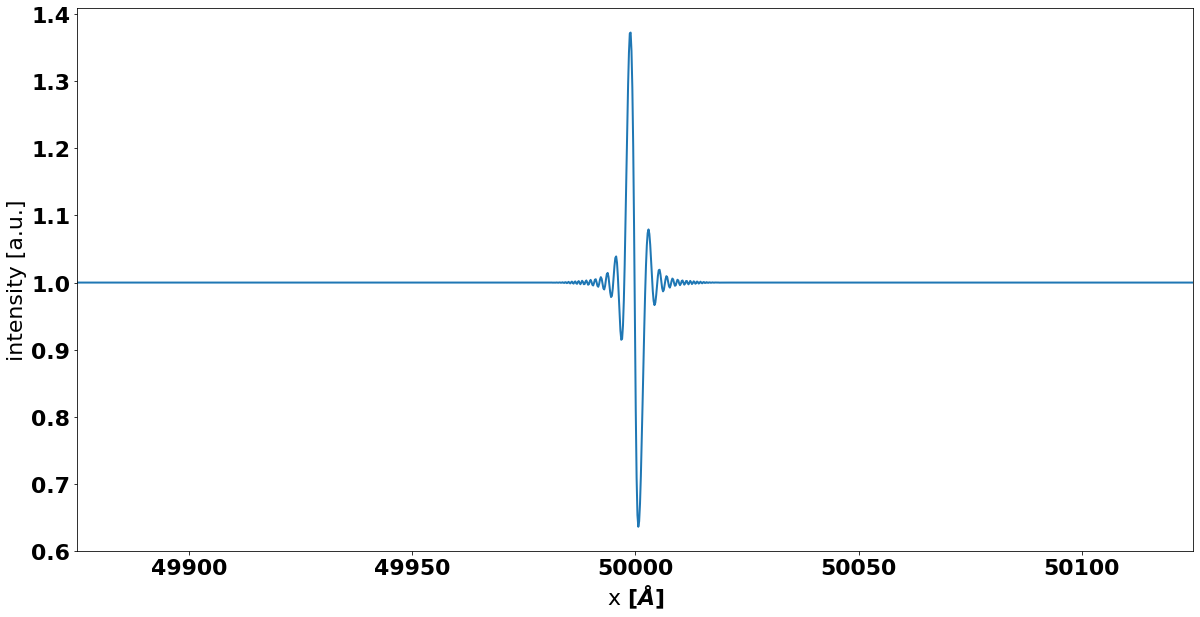

In [8]:
plt.plot(np.linspace(0,extent[0],gpts[0]),exit_wave.intensity().array[0][:,gpts[1]//2])
plt.xlim(np.array([extent[0]/2-extent[0]/800,extent[0]/2+extent[0]/800]))
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"x $[\AA]$")

Incoming wave has intensity 1 a.u. and leaving wave should also be, on the average, close to this value. Otherwise, there won't be high enough spatial frequencies. 

In [9]:
np.mean(exit_wave.intensity().array[0])

0.99999994

We create and show the contrast transfer function (CTF), see [docs](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html) for a description of the parameters.

CTF is created from parameters of the electron beam, aperture angle, partial coherence and aberration coefficients up to fifth order.
The main parameters are:
* `energy` beam energy
* spherical aberration `Cs` is equivalent to coefficient C3 in Haider's notation
* defocus `defocus` is equivalent to coefficient -C1 in Haider's notation
* `focal_spread` is quantity accounting for temporal coherence with given coefficient of chromatic aberration `Cc`
* `angular_spread` accounts for spatial coherence. It is $1/e$ of width of the distribution of angles
* `semiangle_cutoff` semi-angle of aperture 

Parameters of CTF are:

`energy` = $200$ keV

`Cs` = $1.2$ mm

`defocus` = $672$ angstrom (optimal Scherzer defocus)

`Cc` = $1.61$ mm

`angular_spread` = $0.1$ mrad 

`semiangle_cutoff` = $10.5$ mrad

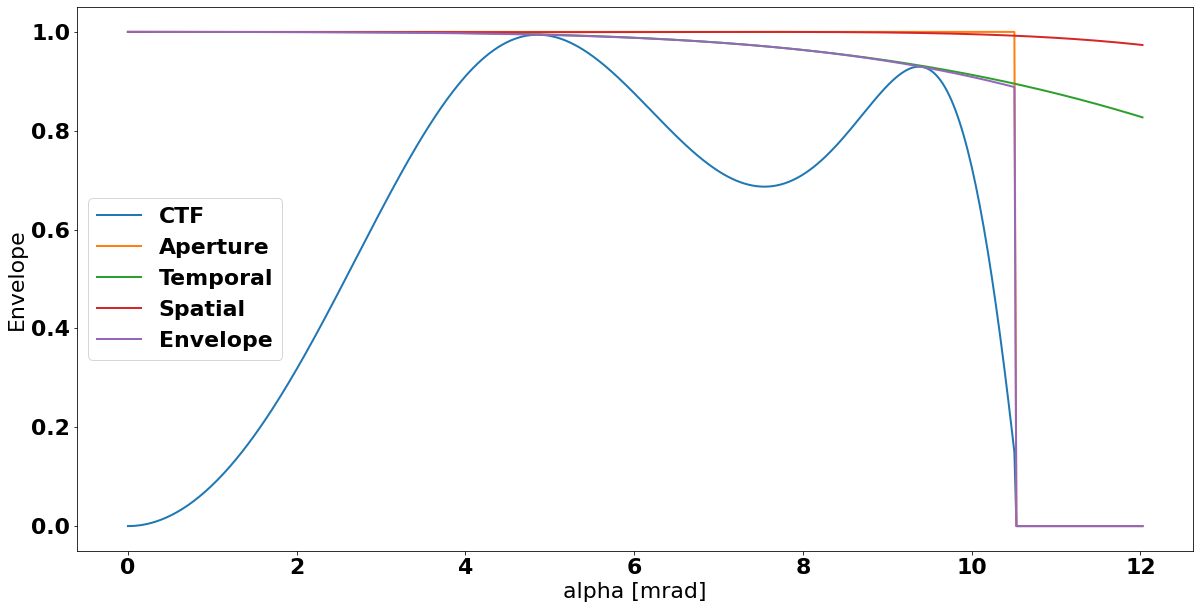

In [10]:
#temporal coherrence
C3 = 1.2e-3/1e-10 #In Angstrom
Cc = 1.61e-3/1e-10 # In Angstrom
focal_spread=Cc*(0.6/energy)

#spatial coherrence
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)
reduced_brightness=1e8 
d=80*1e-10 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta

defocus_0 = scherzer_defocus(Cs=C3,energy=energy)
ctf = CTF(
    energy = energy,
    semiangle_cutoff = 10.5, # mrad
    focal_spread = focal_spread, # Å
    angular_spread = angular_spread, #mrad
    defocus = defocus_0, # Å
    Cs = C3, # Å
    rolloff=0.01
)

#ctf = CTF(energy=100e3, **{'defocus':10})

ctf.show(max_semiangle=12);

To simulate an image we apply the CTF of the objective lens. 

In [11]:
image_wave = exit_wave.apply_ctf(ctf)

#image_wave.intensity().show();

#imshow_direct(image_wave.intensity().array[0],extent=(0,extent[0],0,extent[1]));plt.colorbar(label="intensity [a.u.]")
#plt.xlabel("x [$\mathrm{\AA}$]")
#plt.ylabel("y [$\mathrm{\AA}$]")

#plt.plot(np.linspace(0,extent[0],gpts[0])*1e-10/1e-6,image_wave.intensity().array[0][:,gpts[1]//2])
#plt.ylabel(r"intensity [a.u.]")
#plt.xlabel(r"x $[\mu m]$")

Zoomed cut alonx x direction in image

Text(0.5, 0, 'x $[\\mu m]$')

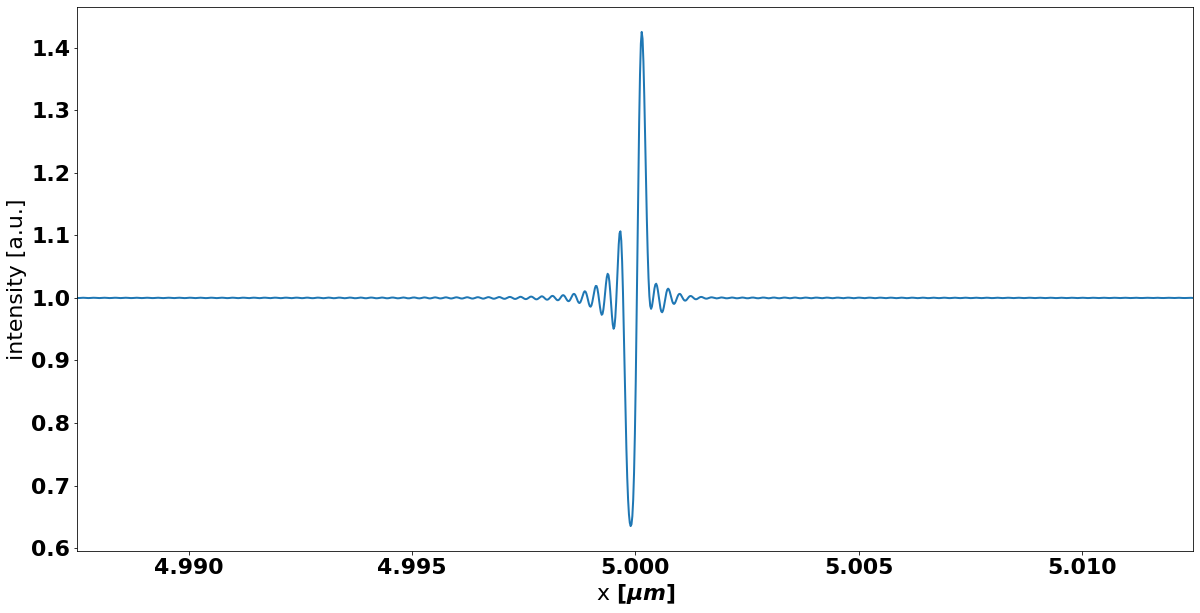

In [12]:
plt.plot(np.linspace(0,extent[0],gpts[0])*1e-10/1e-6,image_wave.intensity().array[0][:,gpts[1]//2])
plt.xlim(np.array([extent[0]/2-extent[0]/800,extent[0]/2+extent[0]/800])*1e-10/1e-6)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"x $[\mu m]$")

Diffraction pattern of the image

Text(0.5, 0, 'alpha_x $[m rad]$')

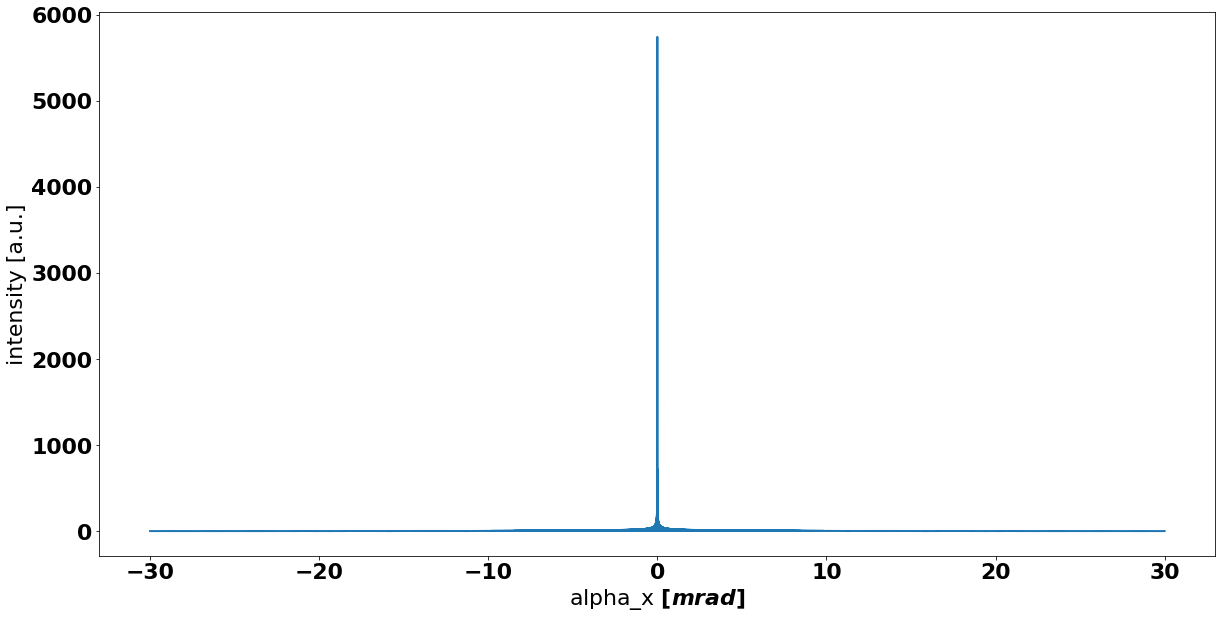

In [13]:
#%matplotlib qt
#image_wave.diffraction_pattern(max_angle=30, block_zeroth_order=0, ).show(power=.3);

diff_pattern = exit_wave.diffraction_pattern(max_angle=30, block_zeroth_order=0, )
diff_pattern_array = diff_pattern.array[0]**0.3

limits = diff_pattern.calibration_limits
alpha_x_limit = limits[1]
alpha_y_limit = limits[2]

#imshow_direct(diff_pattern_array,cmap="gray",extent=np.array((alpha_x_limit[0],alpha_x_limit[1],alpha_y_limit[0],alpha_y_limit[1])));plt.figure()
#plt.colorbar(label="intensity [a.u.]",orientation="horizontal")
#plt.xlim(-0.15,0.15)
#plt.ylim(-1,1)



diff_gpts = np.shape(diff_pattern_array)
y=diff_pattern_array[:,diff_gpts[1]//2]
plt.plot(np.linspace(alpha_x_limit[0],alpha_x_limit[1],len(y)),y)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"alpha_x $[m rad]$")

Zoomed diffraction pattern of the image

Text(0.5, 0, 'alpha_x $[m rad]$')

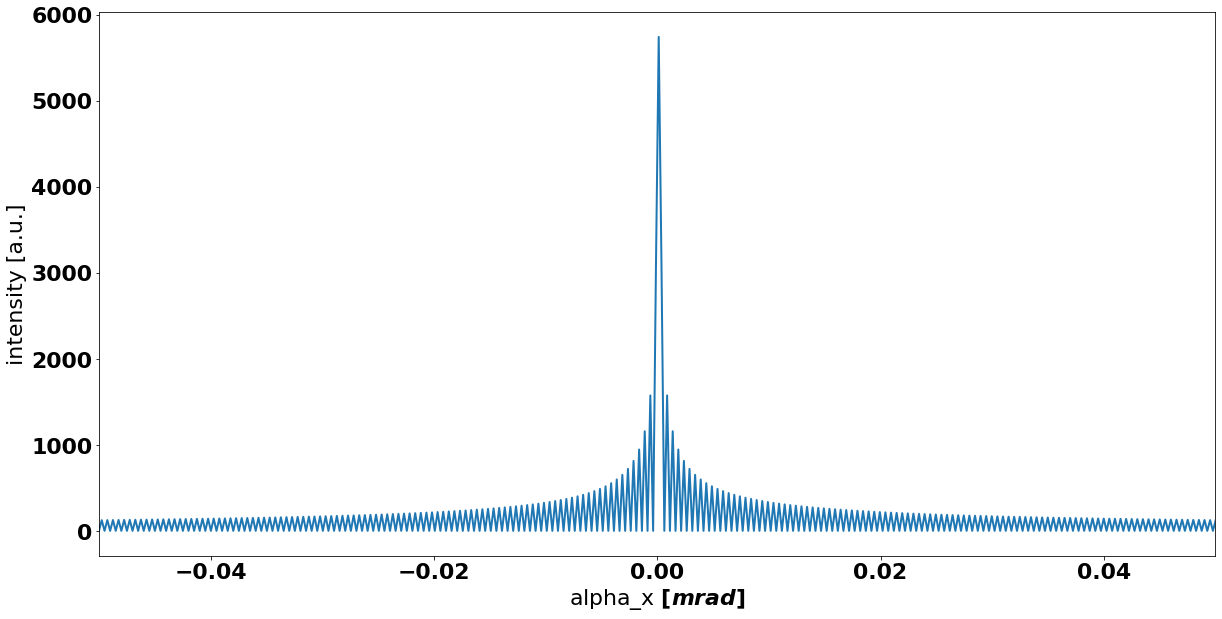

In [14]:
diff_gpts = np.shape(diff_pattern_array)
y=diff_pattern_array[:,diff_gpts[1]//2]
plt.plot(np.linspace(alpha_x_limit[0],alpha_x_limit[1],len(y)),y)
plt.xlim(np.array([-0.05,0.05]))
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"alpha_x $[m rad]$")

# TEM sensitivity on phase shift

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.19073486 0.19073486]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'x $[\\mu m]$')

/home/zvonek/.virtualenvs/abtem_dev/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/zvonek/.virtualenvs/abtem_dev/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


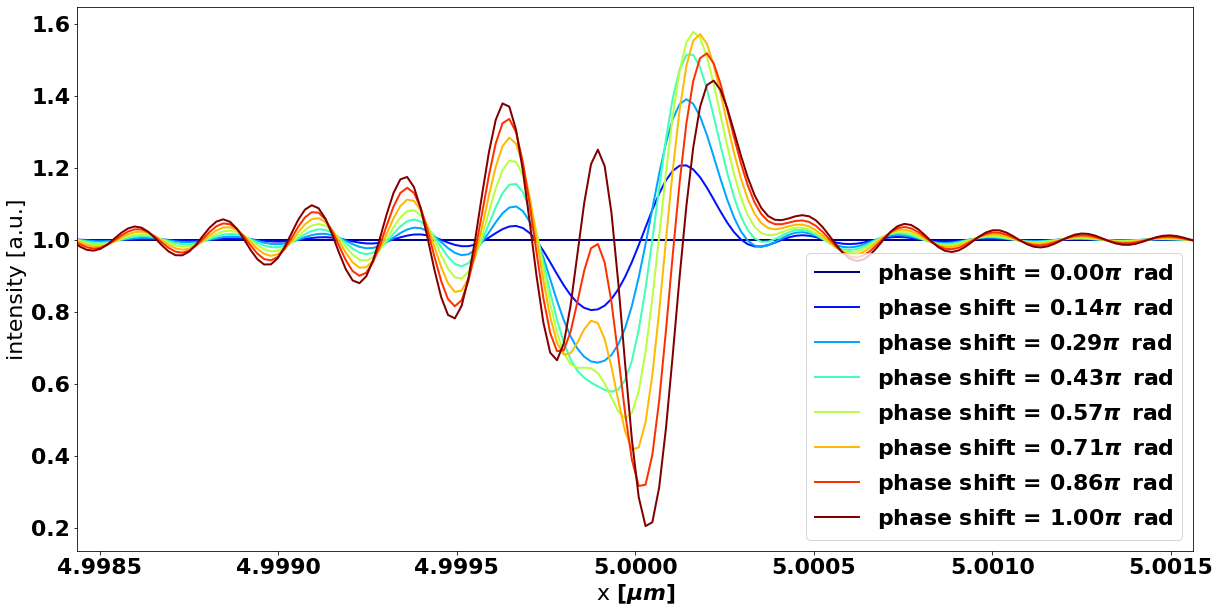

In [15]:
lines = 8
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]


for phase_shift_i,phase_shift in enumerate(np.linspace(0,np.pi,lines)):
    potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
    wave = PlaneWave(
        energy=energy,extent=extent,sampling=sampling # acceleration voltage in eV
    )

    exit_wave = wave.multislice(potential)
    image_wave = exit_wave.apply_ctf(ctf)
    exit_wave=image_wave
    plt.plot(np.linspace(0,extent[0],gpts[0])*1e-10/1e-6,exit_wave.intensity().array[0][:,gpts[1]//2],label=r"phase shift = ${:.2f}\pi\,$ rad".format(phase_shift/np.pi),color=colors[phase_shift_i])
    
plt.xlim(np.array([extent[0]/2-extent[0]/6400,extent[0]/2+extent[0]/6400])*1e-10/1e-6)
plt.legend()
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"x $[\mu m]$")


# STEM simulation of phase plate

Creating potential with $50 \, \mathrm{nm}$ extent in both dimensions.

In [16]:
ex = 0.05e-6/1e-10 # A # sample dimensions in x and y direction # pro TEM
extent = np.array([ex, ex])
gpts=np.array([2048,2048])
sampling = extent/gpts
potential = get_potential(phase_shift=1,extent=extent,energy=energy,gpts=gpts,num=num)

[0.24414062 0.24414062]


Parameters of CTF are:

`energy` = $200$ keV (electron beam energy)

`Cs` = $1.2$ mm (spherical aberration)

`defocus` = $0.5\,\mathrm{\mu m}$ (defocus)

`Cc` = $1.61$ mm (chromatic aberration)

`angular_spread` = $0.1$ mrad 

`semiangle_cutoff` = $10.5$ mrad (aperture semiangle angle)

Creating a probe object and displaying a CTF of an objective lens. 

<AxesSubplot:xlabel='alpha [mrad]', ylabel='Envelope'>

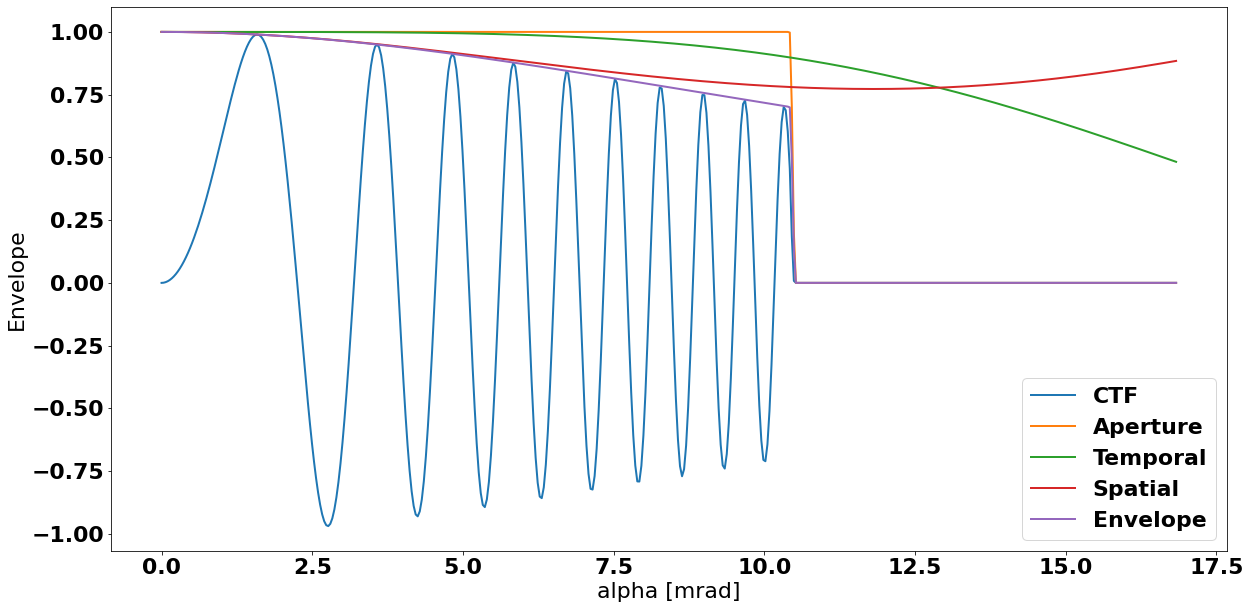

In [17]:
high_defocus = 5e-7/1e-10
semiangle_cutoff = 10.5
probe = Probe(energy=energy, defocus=high_defocus, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, Cs=C3, focal_spread=focal_spread, angular_spread=angular_spread);probe.grid.match(potential)
probe.ctf.show()

Aperture function

Text(0.5, 0, 'alpha_x [mrad]')

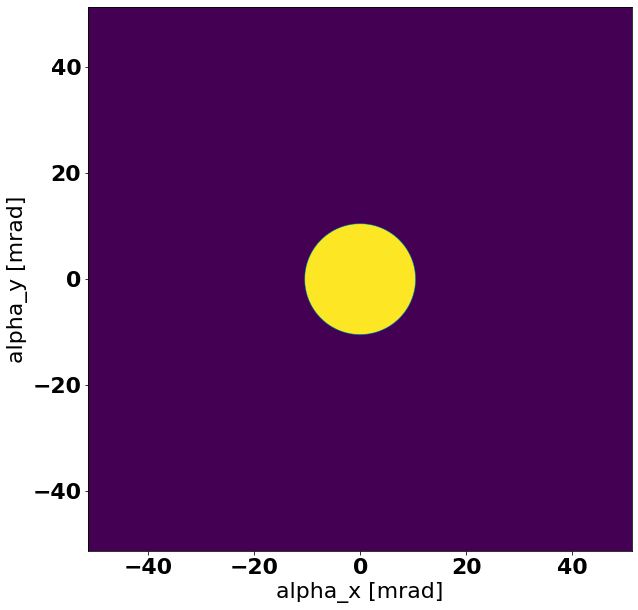

In [18]:
#%matplotlib qt
alpha_x, alpha_y = probe.get_spatial_frequencies()
alpha, phi = probe.get_scattering_angles()
alpha_x= alpha_x*probe.wavelength;alpha_y = alpha_y*probe.wavelength
ap_extent=np.array((np.min(alpha_x),np.max(alpha_x),np.min(alpha_y),np.max(alpha_y)))*1e3 # extent will be [mrad]
plt.imshow(np.abs(fft_shift(probe.ctf.evaluate_aperture(alpha,phi),np.array(gpts//2))),extent=ap_extent)
plt.ylabel("alpha_y [mrad]")
plt.xlabel("alpha_x [mrad]")

Displaying probe in real space

(199.99999999999997, 299.99999999999994)

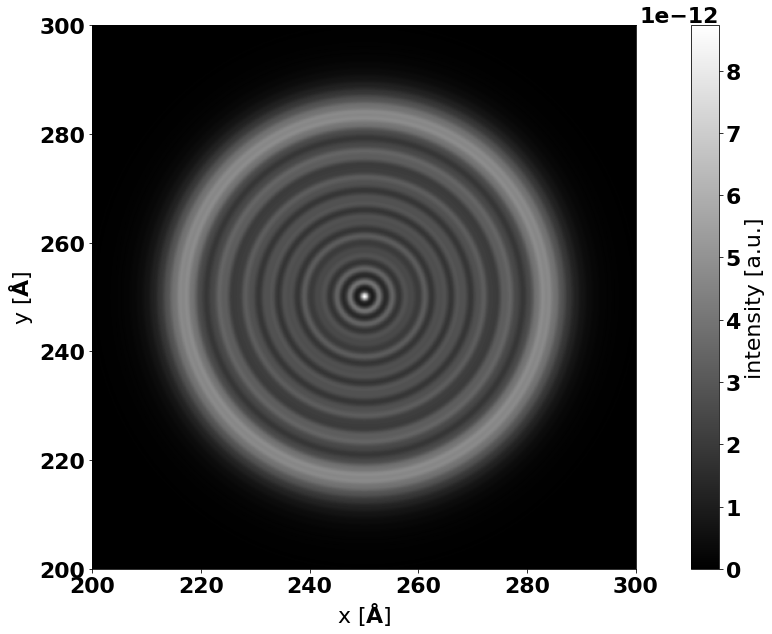

In [19]:
#%matplotlib qt
#probe.show()
imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

Performing multislice simulation

In [20]:
center_pos = sampling*gpts//2
measurement = probe.multislice(positions=center_pos, potential=potential)

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Intensity of the probe after passing through the sample

(199.99999999999997, 299.99999999999994)

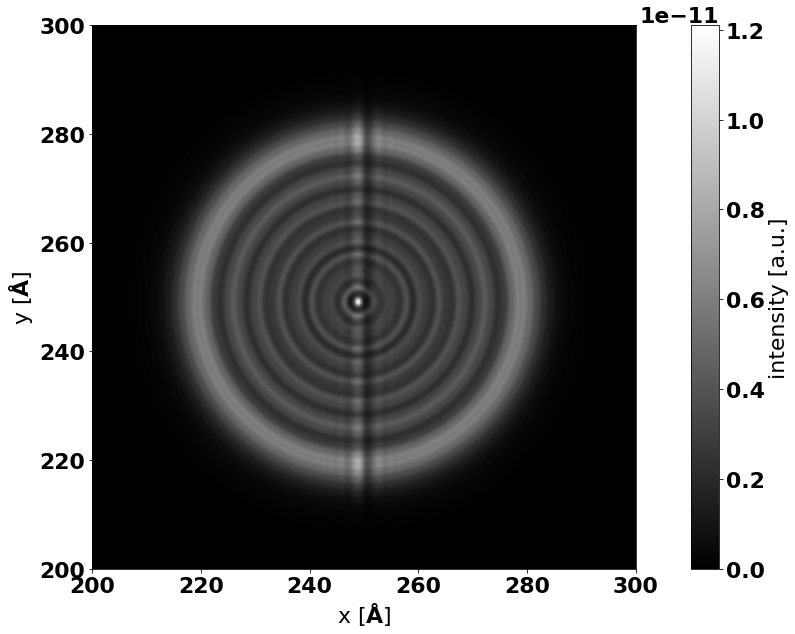

In [21]:
imshow_direct(measurement.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

Showing STEM diffractive pattern

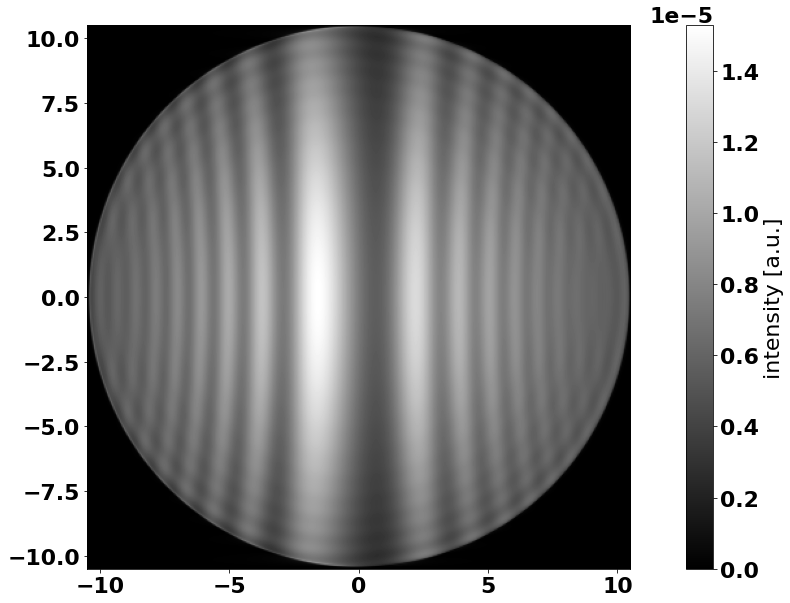

In [22]:
#%matplotlib qt
#measurement.diffraction_pattern().show()
limits = measurement.diffraction_pattern().calibration_limits
limits_x = limits[1]
limits_y = limits[2]
dif_pattern = measurement.diffraction_pattern()
dif_pattern_array = dif_pattern.array[0]
imshow_direct(measurement.diffraction_pattern().array[0],cmap="gray",extent=np.array((limits_x[0],limits_x[1],limits_y[0],limits_y[1])))
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylim(-semiangle_cutoff,semiangle_cutoff)
plt.colorbar(label="intensity [a.u.]")

Cut along x direction in diffraction pattern

Text(0.5, 0, 'alpha_x [mrad]')

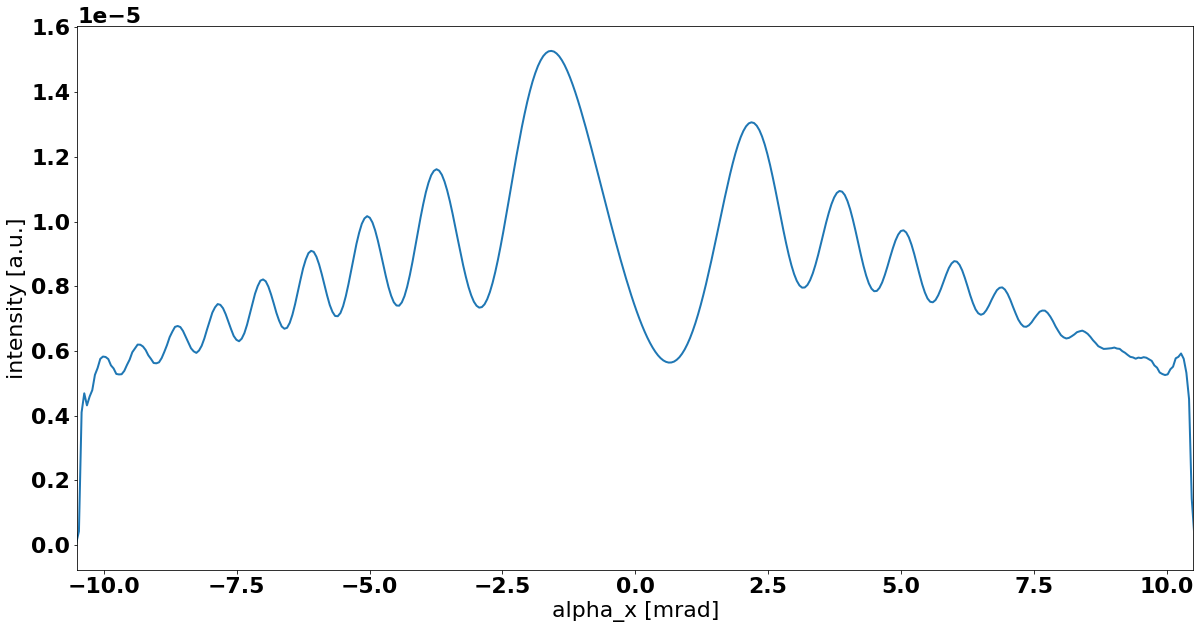

In [23]:
y_center = np.shape(dif_pattern_array)[1]//2 # y axis index in the middle of diffraction pattern
y = dif_pattern_array[:,y_center]

x_limits = dif_pattern.calibration_limits[1]
x = np.linspace(x_limits[0],x_limits[1],len(y))

plt.plot(x,y)
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"alpha_x [mrad]")

# STEM sensitivity on phase shift

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'alpha_x [mrad]')

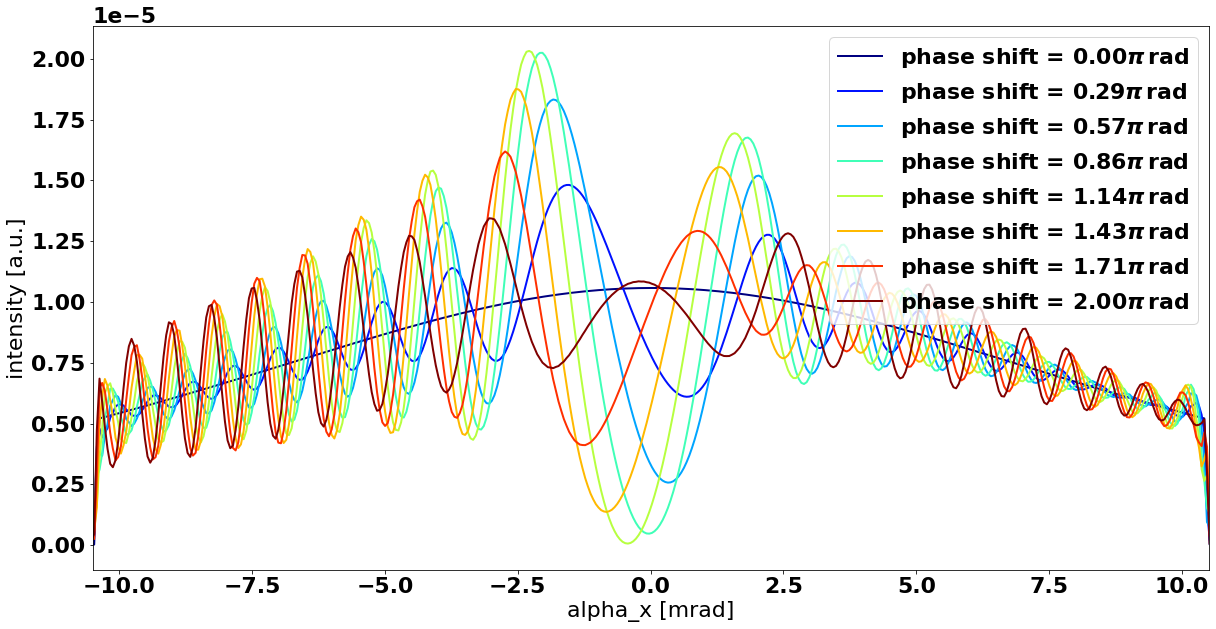

In [24]:
lines = 8
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

for phase_shift_i,phase_shift in enumerate(np.linspace(0,np.pi*2,lines)):
    potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=20)
    measurement = probe.multislice(positions=center_pos, potential=potential)
    #alpha_x, _ = probe.get_spatial_frequencies()
    dif_pattern = measurement.diffraction_pattern()
    dif_pattern_array = dif_pattern.array[0]
    
    y_center = np.shape(dif_pattern_array)[1]//2 # y axis index in the middle of diffraction pattern
    y = dif_pattern_array[:,y_center]
    
    x_limits = dif_pattern.calibration_limits[1]
    x = np.linspace(x_limits[0],x_limits[1],len(y))
    
    plt.plot(x,y,label=r"phase shift = ${:.2f}\pi\,$rad".format(phase_shift/np.pi),color=colors[phase_shift_i])
plt.legend()
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"alpha_x [mrad]")

# STEM sensitivity on an offset from the phase plate edge

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'alpha_x [mrad]')

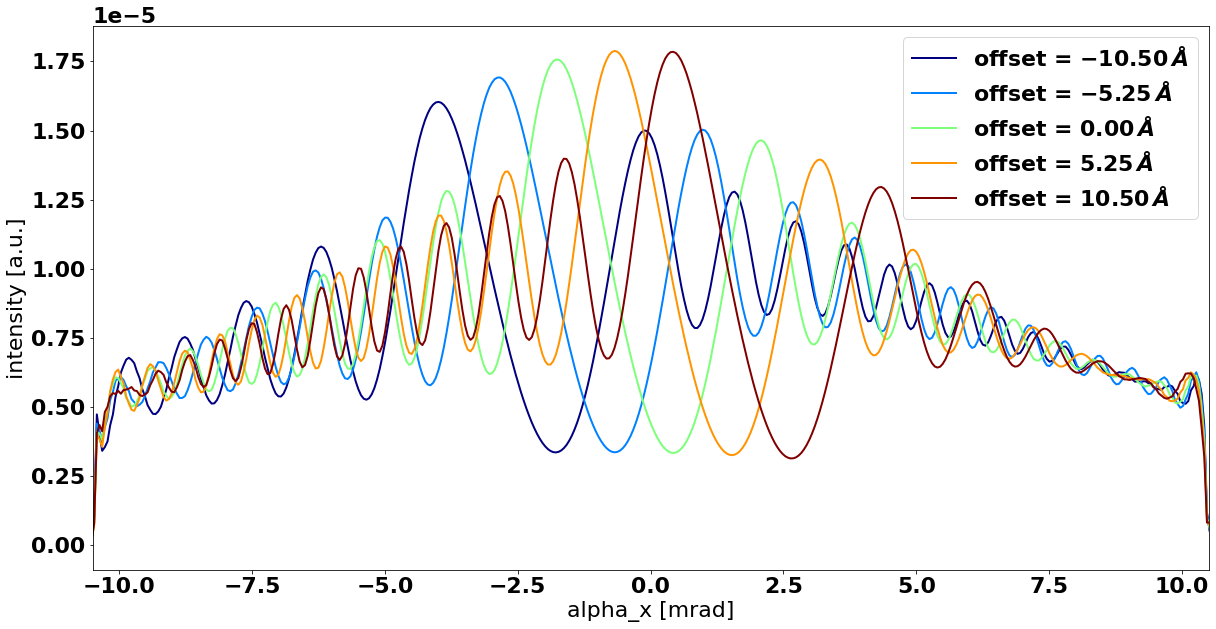

In [25]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

center_pos = sampling*gpts//2
scan_delta_x = high_defocus*semiangle_cutoff*1e-3 # estimate of deviation 
scan_delta_xs = np.linspace(-scan_delta_x,scan_delta_x,lines)/5

phase_shift=np.pi/2

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
for i,_ in enumerate(scan_delta_xs):
    measurement = probe.multislice(positions=center_pos+np.array([1,0])*scan_delta_xs[i], potential=potential)
    #alpha_x, _ = probe.get_spatial_frequencies()
    dif_pattern = measurement.diffraction_pattern()
    dif_pattern_array = dif_pattern.array[0]
    
    y_center = np.shape(dif_pattern_array)[1]//2 # y axis index in the middle of diffraction pattern
    y = dif_pattern_array[:,y_center]
    
    x_limits = dif_pattern.calibration_limits[1]
    x = np.linspace(x_limits[0],x_limits[1],len(y))
    
    plt.plot(x,y,label=r"offset = ${:.2f}\,\AA$".format(scan_delta_xs[i]),color=colors[i])
plt.legend()
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"alpha_x [mrad]")

# STEM with modified aperture

In [26]:
from abtem.aperture import MultipleDeviatedApertures
center=1
each_aperture_angle=0.5
#high_defocus=1e-6/1e-10
high_defocus=5e-6/1e-10
#C3 = 1.2e-3/1e-10 #In Angstrom
energy=200e3
potential = get_potential(phase_shift=np.pi/3,extent=extent,energy=energy,gpts=gpts,num=num)
aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angle,x_0=[0,0],y_0=[-center,center])
probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=10.5, rolloff=0.1, Cs=C3, focal_spread=focal_spread, angular_spread=angular_spread/2)
probe.grid.match(potential)
#probe.ctf.show()

[0.24414062 0.24414062]


Aperture function

Text(0.5, 0, 'alpha_x [mrad]')

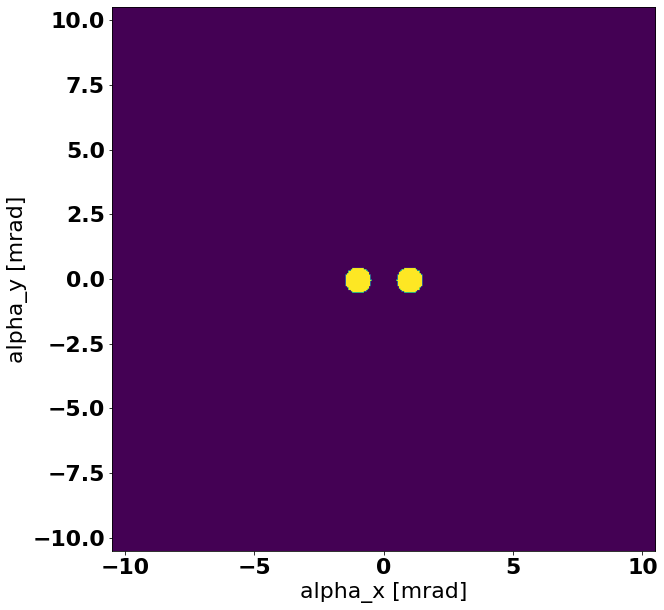

In [27]:
#%matplotlib qt
alpha_x, alpha_y = probe.get_spatial_frequencies()
alpha, phi = probe.get_scattering_angles()
alpha_x= alpha_x*probe.wavelength;alpha_y = alpha_y*probe.wavelength
ap_extent=np.array((np.min(alpha_x),np.max(alpha_x),np.min(alpha_y),np.max(alpha_y)))*1e3 # extent will be [mrad]
plt.imshow(np.swapaxes(np.abs(fft_shift(probe.ctf.evaluate_aperture(alpha,phi),np.array(gpts//2))) ,0,1) ,extent=ap_extent)
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylim(-semiangle_cutoff,semiangle_cutoff)
plt.ylabel("alpha_y [mrad]")
plt.xlabel("alpha_x [mrad]")

Contrast transfer function

Text(0.5, 0, 'alpha_x [mrad]')

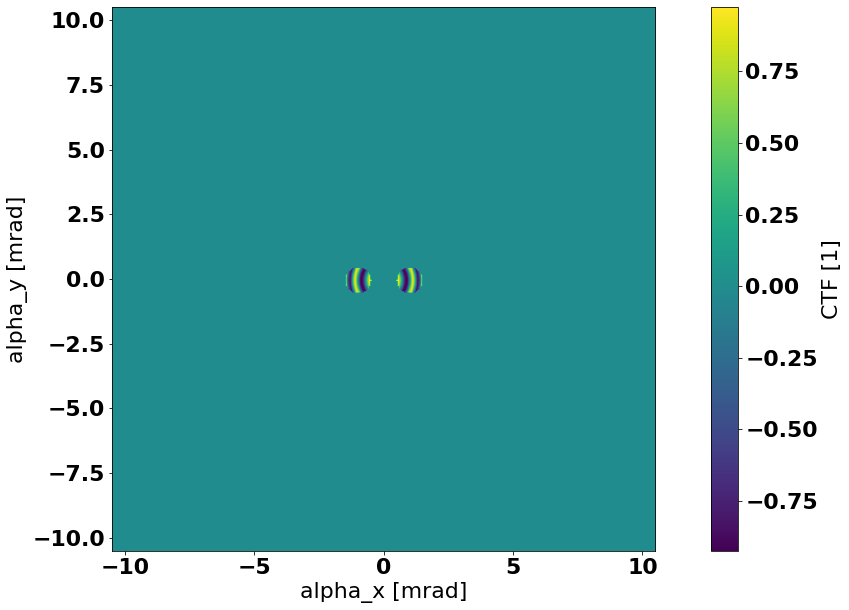

In [28]:
#%matplotlib qt
alpha_x, alpha_y = probe.get_spatial_frequencies()
alpha, phi = probe.get_scattering_angles()
alpha_x= alpha_x*probe.wavelength;alpha_y = alpha_y*probe.wavelength
ap_extent=np.array((np.min(alpha_x),np.max(alpha_x),np.min(alpha_y),np.max(alpha_y)))*1e3 # extent will be [mrad]
plt.imshow(np.swapaxes(np.imag(fft_shift(probe.ctf.evaluate(alpha,phi),np.array(gpts//2))) ,0,1)*np.absolute(np.swapaxes(fft_shift(probe.ctf.evaluate_aperture(alpha,phi),np.array(gpts//2)) ,0,1)) ,extent=ap_extent)
#plt.colorbar(label=r"sin($\chi$)")
plt.colorbar(label="CTF [1]")
plt.xlim(-semiangle_cutoff,semiangle_cutoff)
plt.ylim(-semiangle_cutoff,semiangle_cutoff)
plt.ylabel("alpha_y [mrad]")
plt.xlabel("alpha_x [mrad]")

Probe before hitting the sample 

(150.0, 349.99999999999994)

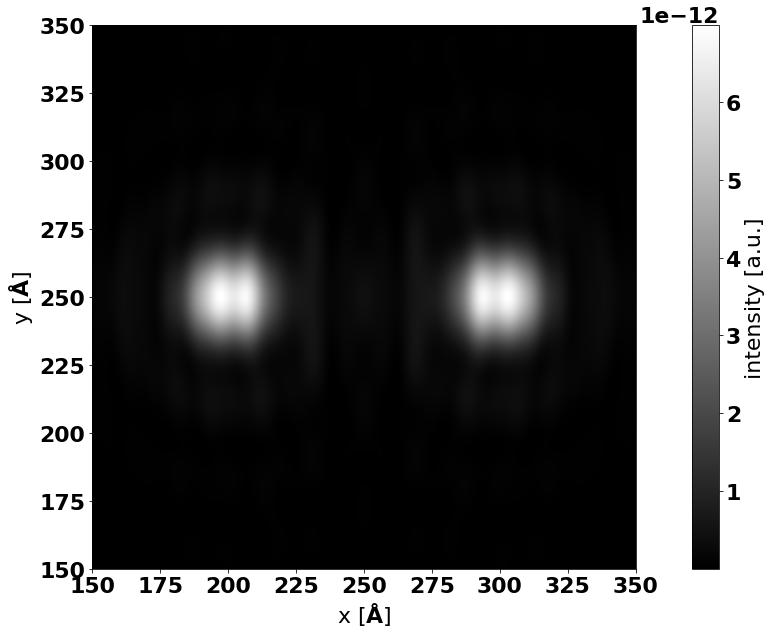

In [29]:
#%matplotlib qt
#probe.show()
imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=5
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

Running multislice simulation

In [30]:
center_pos = sampling*gpts//2
measurement = probe.multislice(positions=center_pos, potential=potential)

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Wave after passing thorugh the sample

(150.0, 349.99999999999994)

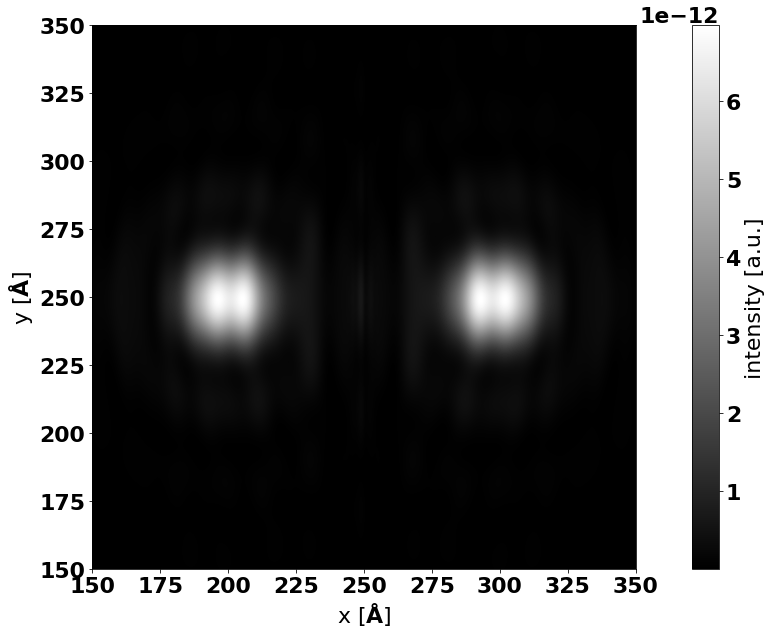

In [31]:
imshow_direct(measurement.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=5
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

Propagating wave into crossover

In [32]:
#inspired by https://github.com/jacobjma/abTEM/issues/56
from abtem.waves import FresnelPropagator
propagator = FresnelPropagator()
delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
print(delta_z)
probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å

11.999995999999731


Wave at crossover

(199.99999999999997, 299.99999999999994)

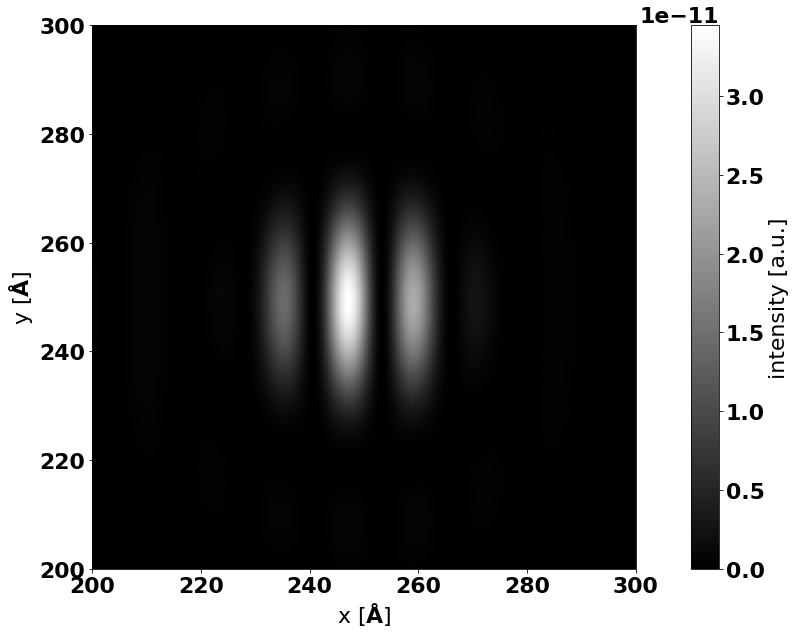

In [33]:
#%matplotlib inline
#probe_propagated.show()
imshow_direct(probe_propagated.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

In [34]:
1/20*probe.wavelength
image_wave_confocal = probe_propagated.apply_ctf(ctf)

Applying TEM's contrast transfer function

(199.99999999999997, 299.99999999999994)

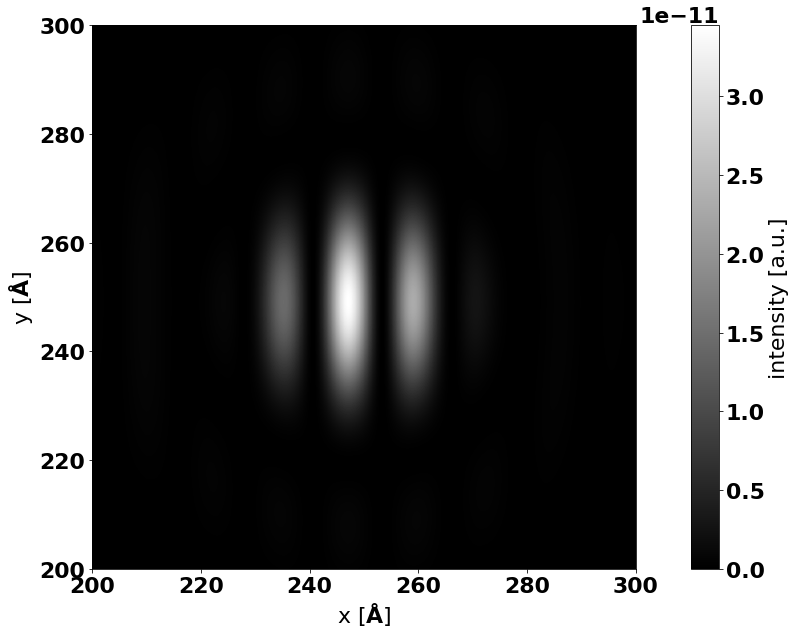

In [35]:
#%matplotlib inline
#probe_propagated.show()
imshow_direct(image_wave_confocal.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
plt.xlim(cent-extent[0]/zoom,cent+extent[0]/zoom)
plt.ylim(cent-extent[1]/zoom,cent+extent[1]/zoom)

Cut along x direction of wave at crossover

(199.99999999999997, 299.99999999999994)

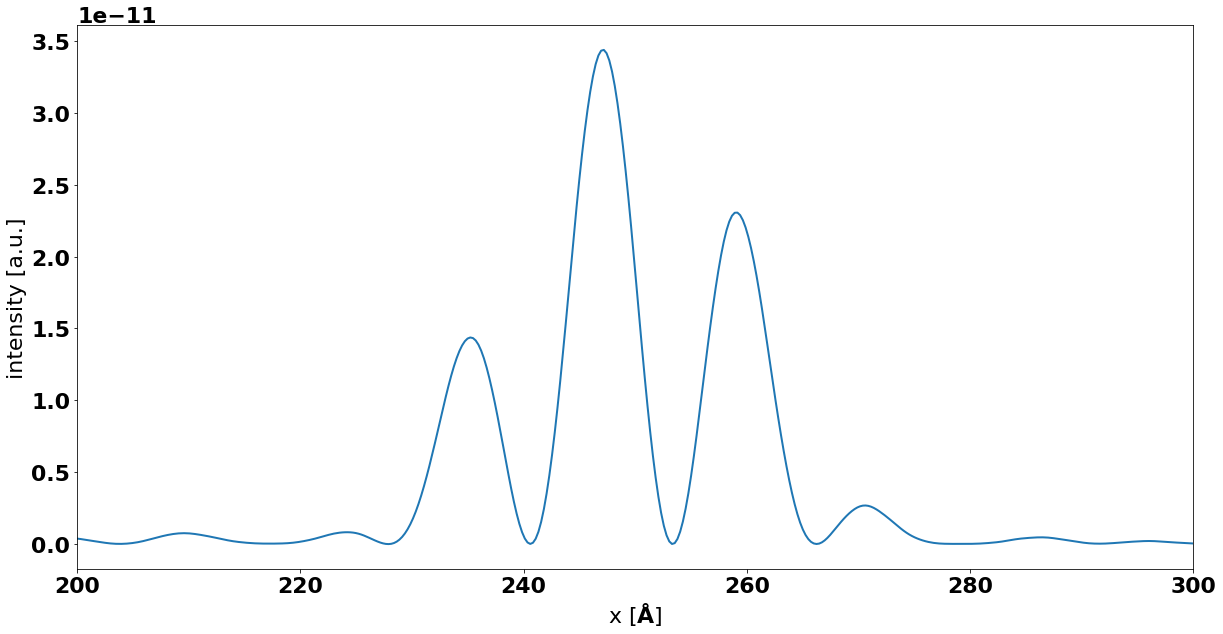

In [36]:
y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
x=np.linspace(0,extent[1],len(y))
plt.plot(x,y)
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")
zoom=10
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

# STEM with modified aperture: sensitivity on phase shift 

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


(199.99999999999997, 299.99999999999994)

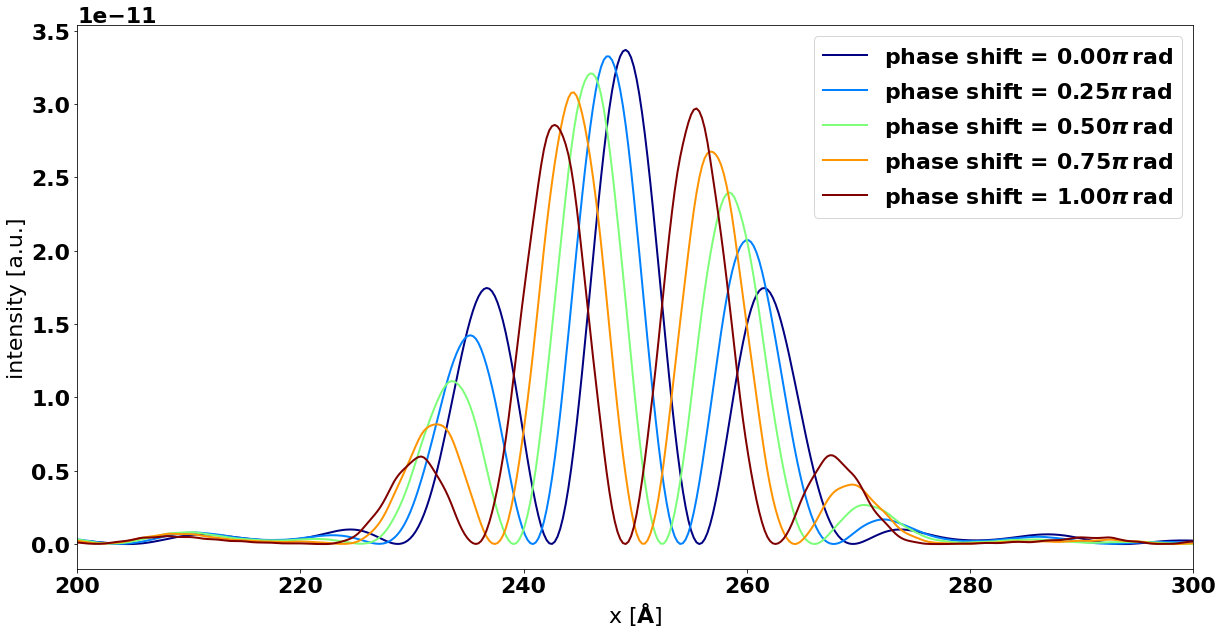

In [37]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

for phase_shift_i,phase_shift in enumerate(np.linspace(0,np.pi,lines)):
    potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angle,x_0=[0,0],y_0=[-center,center])
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=10.5, rolloff=0.1, Cs=C3, focal_spread=focal_spread, angular_spread=angular_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    y=probe_propagated.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    plt.plot(x,y,label=r"phase shift = ${:.2f}\pi\,$rad".format(phase_shift/np.pi),color=colors[phase_shift_i])
    
plt.legend()
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)



# STEM with modified aperture: sensitivity on the offset 

The probe before hitting the sample consists of two maximas approximately 100 angstrom apart. How image changes on the offset follows. Offset is up to 60 angstrom. 

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'x [$\\AA$]')

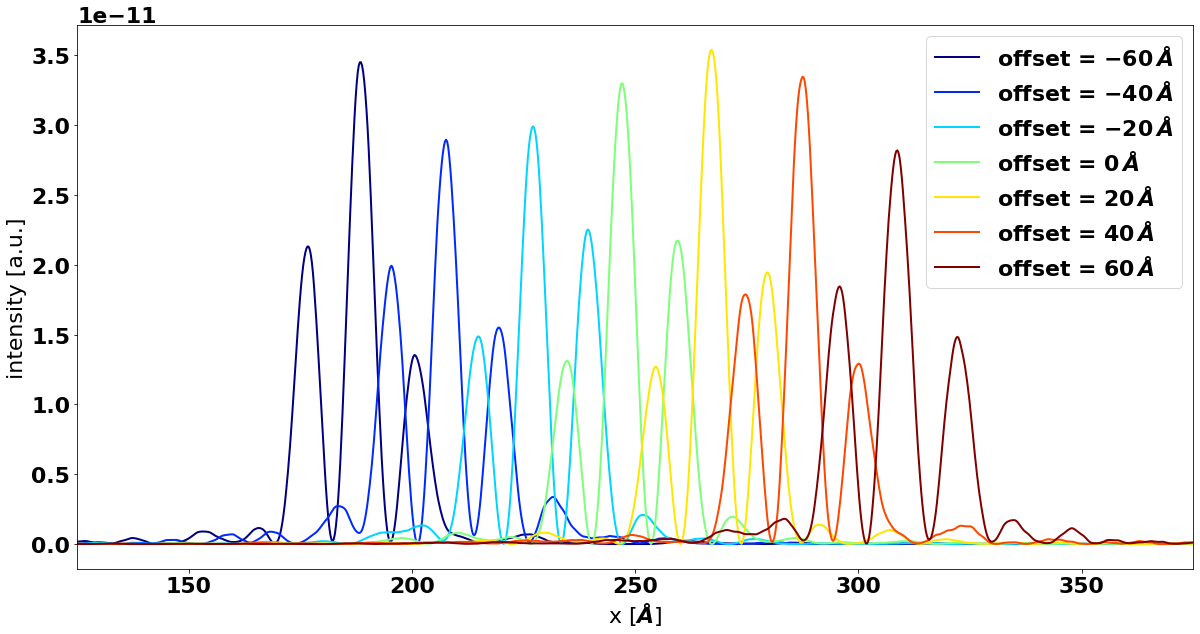

In [38]:
lines = 7
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

center_pos = sampling*gpts//2
scan_delta_x = high_defocus*semiangle_cutoff*1e-3 # estimate of deviation 
#scan_delta_xs = np.linspace(-scan_delta_x,scan_delta_x,lines)/3.5
scan_delta_xs = np.linspace(-60,60,lines)

phase_shift=np.pi/3

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
for i,_ in enumerate(scan_delta_xs):
    measurement = probe.multislice(positions=center_pos+np.array([1,0])*scan_delta_xs[i], potential=potential)
    
    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    y=probe_propagated.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    plt.plot(x,y,label=r"offset = ${:.0f}\,\AA$".format(scan_delta_xs[i]),color=colors[i])
plt.legend()
zoom=4
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)
plt.ylabel(r"intensity [a.u.]")
plt.xlabel(r"x [$\AA$]")